# CSCA 5642: Final project
## Dataset - DDTI: Thyroid Ultrasound Images
Kaggle URL: https://www.kaggle.com/datasets/dasmehdixtr/ddti-thyroid-ultrasound-images/data

URL: http://cimalab.unal.edu.co/?lang=en&mod=project&id=31

> The digital database of Thyroid Ultrasound Images, is an open access resource for the scientific community. The support of this project was provided by Universidad Nacional de Colombia , CIM@LAB and IDIME ( Instituto de Diagnostico Medico). The main purpose of the Dataset is the development of algorithms to apply CAD systems in the analisys of thyroid nodules. On the other hand, the database pretends be using as a training and teaching tool for the new radiologists. The database contains 99 cases and 134 images.

### Background
- This dataset consists of ultrasound images of benign and malignant thyroid nodules.
- Since benign tumors are more common than thyroid cancer, small nodules that appear unlikely to be malignant on imaging are often monitored over time rather than immediately biopsied.
- Therefore, improving the diagnostic accuracy for distinguishing between benign and malignant nodules can reduce unnecessary procedures, minimizing invasiveness and benefiting healthcare economics.

- Unlike abdominal organs, ultrasound provides more useful information than CT when it comes to the thyroid.
- This is because the thyroid is a superficial organ with few anatomical structures obstructing ultrasound transmission between the skin and the gland.


### TIRADS Score

- In this dataset, each thyroid nodule is assigned a score based on the Thyroid Imaging Reporting and Data System (TIRADS).


> Eleonora Horvath, Sergio Majlis, Ricardo Rossi, Carmen Franco, Juan P. Niedmann, Alex Castro, Miguel Dominguez, An Ultrasonogram Reporting System for Thyroid Nodules Stratifying Cancer Risk for Clinical Management, The Journal of Clinical Endocrinology & Metabolism, Volume 94, Issue 5, 1 May 2009, Pages 1748–1751, https://doi.org/10.1210/jc.2008-1724

- TIRADS is a scoring system that classifies the malignancy risk of thyroid nodules from 1 to 5, based on features such as shape and echogenicity.
- TR1 and TR2 are considered benign, and fine-needle aspiration (FNA) biopsy is generally not required.
- Nodules classified as TR3 or higher are considered to carry some risk of malignancy. According to the original paper, TR3 indicates a malignancy risk of less than 5%, TR4 ranges from 5% to 80%, and TR5 indicates a malignancy risk of over 80%.
- For nodules scored TR3 or higher, follow-up or biopsy is recommended depending on the size and other clinical factors.

### Task Definition

- The task is to classify thyroid nodules as benign or malignant (qualitative diagnosis) using convolutional neural networks (CNNs) based on ultrasound images.
- Since the risk of malignancy increases significantly from TR4 onward (TR3 < 5% vs. TR4: 5–80%), the classification task is defined as **a binary classification between "TR3 or below" and "TR4 or above."**
- While distinguishing nodules that are TR2 or below (which typically do not require biopsy) would also be clinically meaningful, it would create severe class imbalance issues, making the task more technically difficult. Therefore, we adopt the aforementioned classification boundary.
- Successfully solving this task with AI may lead to more appropriate medical interventions.

### Evaluation Metrics

- Due to significant class imbalance, careful selection of evaluation metrics is necessary.
- This dataset likely contains a higher proportion of suspicious (potentially malignant) cases compared to actual clinical settings.
- In disease diagnosis tasks, not only accuracy but also sensitivity and specificity are important.

Considering the above, **macro F1** was used as the primary evaluation metric:
- It provides a balanced evaluation of classification performance in terms of both precision and recall.
- As a macro-average, it places equal importance on the minority class (benign tumors), making it suitable for imbalanced datasets.

In addition, several other evaluation metrics were used as secondary indicators.


In [1]:
!pip install keras-rectified-adam

  Preparing metadata (setup.py) ... done
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.20.0-py3-none-any.whl size=8253 sha256=62de44d42cf681b26bf053c037403b82116beb18fd054552eaa75d651b2366a6
  Stored in directory: /root/.cache/pip/wheels/db/4c/0d/1cdd142515ae041ea7a270d543b3efb6336587a8bd99c3aa6f
Successfully built keras-rectified-adam


In [3]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import random
import os
from tqdm import tqdm
import cv2
import xml.etree.ElementTree as ET


seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data (34 points)

In [4]:
data_dir = "/content/drive/My Drive/Education/CU/ML3/Final/data"
metadata = []

for filename in tqdm(os.listdir(data_dir)):
    if filename.endswith(".xml"):
        case_number = int(filename[:-4])
        xml_path = os.path.join(data_dir, filename)

        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Extract metadata
        tirads = root.find(".//tirads").text
        age = root.find(".//age").text
        sex = root.find(".//sex").text
        composition = root.find(".//composition").text
        echogenicity = root.find(".//echogenicity").text
        margins = root.find(".//margins").text
        calcifications = root.find(".//calcifications").text

        num_images = 0
        image_paths = []
        for img_filename in os.listdir(data_dir):
            if img_filename.startswith(str(case_number) + "_") and img_filename.endswith(".jpg"):
                num_images += 1
                image_paths.append(os.path.join(data_dir, img_filename))
        metadata.append([case_number, num_images, image_paths[0], tirads, age, sex, composition, echogenicity, margins, calcifications])

df = pd.DataFrame(metadata, columns=["case_number", "num_images", "first_image", "tirads", "age", "sex", "composition", "echogenicity", "margins", "calcifications"])
df

100%|██████████| 871/871 [00:19<00:00, 43.70it/s] 


,case_number,num_images,first_image,tirads,age,sex,composition,echogenicity,margins,calcifications
0,108,1,/content/drive/My Drive/Education/CU/ML3/Final...,4a,73,F,predominantly cystic,isoechogenicity,well defined,microcalcifications
1,131,1,/content/drive/My Drive/Education/CU/ML3/Final...,4a,49,F,solid,isoechogenicity,well defined,non
2,144,1,/content/drive/My Drive/Education/CU/ML3/Final...,4b,30,F,predominantly cystic,isoechogenicity,well defined,microcalcifications
3,155,1,/content/drive/My Drive/Education/CU/ML3/Final...,4c,56,M,solid,hypoechogenicity,microlobulated,microcalcifications
4,149,1,/content/drive/My Drive/Education/CU/ML3/Final...,None,78,M,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
385,291,1,/content/drive/My Drive/Education/CU/ML3/Final...,4b,78,F,None,None,well defined smooth,microcalcification
386,274,1,/content/drive/My Drive/Education/CU/ML3/Final...,None,None,None,None,None,None,None
387,286,1,/content/drive/My Drive/Education/CU/ML3/Final...,4b,35,u,solid,isoechogenicity,well defined,microcalcifications
388,392,1,/content/drive/My Drive/Education/CU/ML3/Final...,4c,40,F,None,None,ill- defined,microcalcification


### Remove `None` Category Samples

Some samples have a `None` value for their TIRADS score, so these will be investigated in detail.


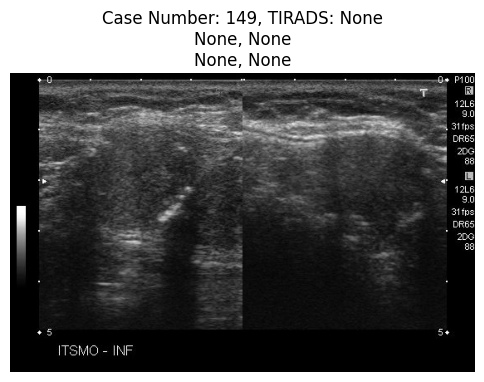

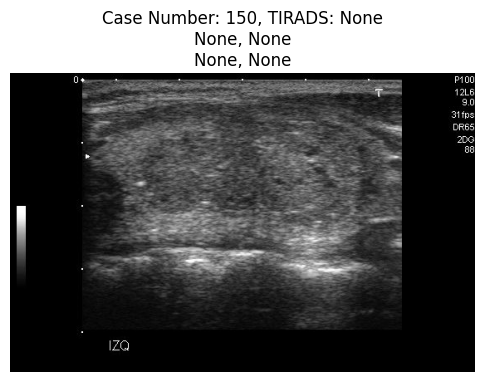

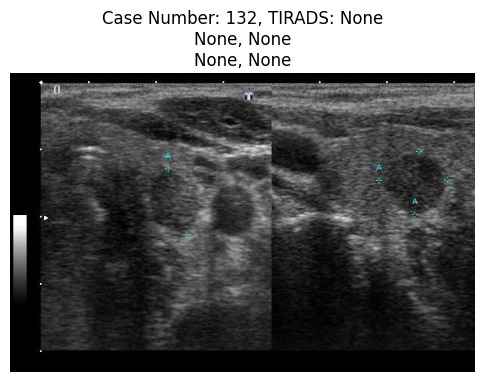

In [5]:
none_tirads_df = df[df['tirads'].isnull()]
for i in range(min(3, len(none_tirads_df))):
    case_num = none_tirads_df.iloc[i]['case_number']
    composition = none_tirads_df.iloc[i]['composition']
    echogenicity = none_tirads_df.iloc[i]['echogenicity']
    margins = none_tirads_df.iloc[i]['margins']
    calcifications = none_tirads_df.iloc[i]['calcifications']
    image_path = none_tirads_df.iloc[i]['first_image']

    img = cv2.imread(image_path)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Case Number: {case_num}, TIRADS: None\n{composition}, {echogenicity}\n{margins}, {calcifications}")
    plt.axis('off')
    plt.show()

- Not only is the TIRADS score missing, but there are also no other recorded findings for these samples.
- Since the exact labels are unknown, these samples were excluded as part of the data cleaning process.


In [6]:
df = df.dropna(subset=['tirads'])

### Inspecting each category and defining labels

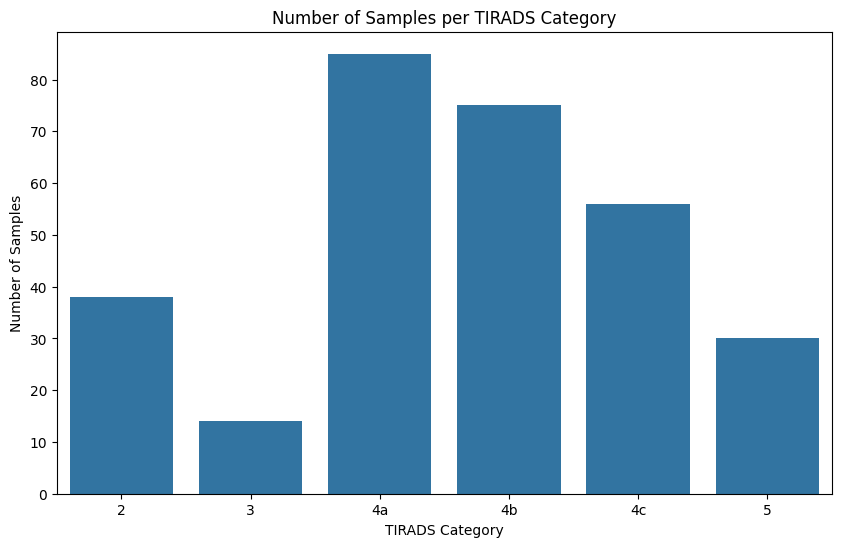

In [7]:
category_order = ['2', '3', '4a', '4b', '4c', '5']

plt.figure(figsize=(10, 6))
sns.countplot(x='tirads', data=df, order=category_order)
plt.xlabel('TIRADS Category')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per TIRADS Category')
plt.show()

- Due to a significant imbalance in the number of samples, it will likely be necessary to apply data augmentation to the negative class samples.

- In this dataset, not only the TIRADS score but also some of the findings used in TIRADS assessment such as composition and echogenicity are provided.
- However, features like shape are not included, making the information insufficient for complete TIRADS scoring.
- If all the features used for scoring were available, it might be more effective to redefine the task as predicting each individual finding. By doing so, each class would become more homogeneous.
- For example, even within TR4, the imaging findings could differ depending on whether the high score is due to echogenicity, margin characteristics, or other findings. Defining classes based solely on one feature such as echogenicity could reduce intra-class heterogeneity, thus improving accuracy.
- Although adding these finding labels as input to the model could improve performance, that model would be useless in clinical settings because human physicians or technicians have to interpret the images before AI prediction.


In [8]:
def display_images_by_category(df, category_column='tirads', category_values=['2', '3', '4a', '4b', '4c', '5']):
    fig, axes = plt.subplots(len(category_values), 3, figsize=(15, 5 * len(category_values)))

    for i, category in enumerate(category_values):
        category_df = df[df[category_column] == category]

        for j in range(min(3, len(category_df))):
          case_num = category_df.iloc[j]['case_number']
          composition = category_df.iloc[j]['composition']
          echogenicity = category_df.iloc[j]['echogenicity']
          margins = category_df.iloc[j]['margins']
          calcifications = category_df.iloc[j]['calcifications']
          image_path = category_df.iloc[j]['first_image']
          img = cv2.imread(image_path)
          if img is not None:
              axes[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
              axes[i, j].set_title(f"Case {case_num}, {category_column}: {category}\n{composition}, {echogenicity}\n{margins}, {calcifications}")
              axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

display_images_by_category(df)

Output hidden; open in https://colab.research.google.com to view.

In [9]:
df['suspicious'] = df['tirads'].apply(lambda x: 1 if x in ['4a', '4b', '4c', '5'] else 0)
df

<ipython-input-9-019fad1cc04b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['suspicious'] = df['tirads'].apply(lambda x: 1 if x in ['4a', '4b', '4c', '5'] else 0)


,case_number,num_images,first_image,tirads,age,sex,composition,echogenicity,margins,calcifications,suspicious
0,108,1,/content/drive/My Drive/Education/CU/ML3/Final...,4a,73,F,predominantly cystic,isoechogenicity,well defined,microcalcifications,1
1,131,1,/content/drive/My Drive/Education/CU/ML3/Final...,4a,49,F,solid,isoechogenicity,well defined,non,1
2,144,1,/content/drive/My Drive/Education/CU/ML3/Final...,4b,30,F,predominantly cystic,isoechogenicity,well defined,microcalcifications,1
3,155,1,/content/drive/My Drive/Education/CU/ML3/Final...,4c,56,M,solid,hypoechogenicity,microlobulated,microcalcifications,1
5,10,1,/content/drive/My Drive/Education/CU/ML3/Final...,4b,74,F,solid,hyperechogenicity,spiculated,microcalcifications,1
...,...,...,...,...,...,...,...,...,...,...,...
384,369,1,/content/drive/My Drive/Education/CU/ML3/Final...,2,60,F,None,None,well defined smooth,non,0
385,291,1,/content/drive/My Drive/Education/CU/ML3/Final...,4b,78,F,None,None,well defined smooth,microcalcification,1
387,286,1,/content/drive/My Drive/Education/CU/ML3/Final...,4b,35,u,solid,isoechogenicity,well defined,microcalcifications,1
388,392,1,/content/drive/My Drive/Education/CU/ML3/Final...,4c,40,F,None,None,ill- defined,microcalcification,1


### Cropping Images

- The bottom and side areas of the images often contain metadata outside the field of view (FOV), which can be misleading. For example, a TIRADS 3 case might have "4A" written on the image.
- While it may be possible to utilize this metadata to improve model performance by consulting the dataset creators about the context of image acquisition, this is difficult given the nature of this project.
- Therefore, metadata displayed outside the FOV should be removed as much as possible.
- Fortunately, most images have a similarly positioned FOV, so it appears feasible to exclude the metadata by referencing pixel positions determined in advance.
- It might also be possible to crop each image at an optimal size. However, for this project, a technically simpler method was chosen.

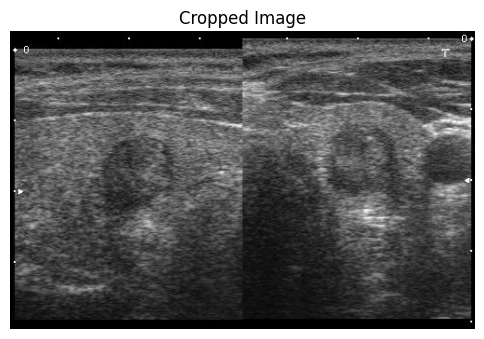

Height: 320, Width: 500


In [10]:
image_path = df['first_image'].iloc[3]

img = cv2.imread(image_path)

# We adjusted these numbers by trials and errors
left = 30
right = 30
bottom = 40

height, width, _ = img.shape
cropped_img = img[0:height - bottom, left:width - right]

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.title("Cropped Image")
plt.axis('off')
plt.show()


img_height, img_width = cropped_img.shape[:2] # These values will be used in training
print(f"Height: {img_height}, Width: {img_width}")

In [11]:
preprocessed_images_dir = os.path.join(data_dir, "preprocessed_images")
os.makedirs(preprocessed_images_dir, exist_ok=True)

for index, row in tqdm(df.iterrows(), total=len(df)):
    image_path = row['first_image']
    img = cv2.imread(image_path)

    if img is not None:
        height, width, _ = img.shape
        cropped_img = img[0:height - bottom, left:width - right]

        filename = os.path.basename(image_path)
        new_image_path = os.path.join(preprocessed_images_dir, filename)

        # Save the cropped image
        cv2.imwrite(new_image_path, cropped_img)
        df.loc[index, 'first_image'] = new_image_path
    else:
        print(f"Could not load image at path: {image_path}")
df

100%|██████████| 298/298 [04:06<00:00,  1.21it/s]


,case_number,num_images,first_image,tirads,age,sex,composition,echogenicity,margins,calcifications,suspicious
0,108,1,/content/drive/My Drive/Education/CU/ML3/Final...,4a,73,F,predominantly cystic,isoechogenicity,well defined,microcalcifications,1
1,131,1,/content/drive/My Drive/Education/CU/ML3/Final...,4a,49,F,solid,isoechogenicity,well defined,non,1
2,144,1,/content/drive/My Drive/Education/CU/ML3/Final...,4b,30,F,predominantly cystic,isoechogenicity,well defined,microcalcifications,1
3,155,1,/content/drive/My Drive/Education/CU/ML3/Final...,4c,56,M,solid,hypoechogenicity,microlobulated,microcalcifications,1
5,10,1,/content/drive/My Drive/Education/CU/ML3/Final...,4b,74,F,solid,hyperechogenicity,spiculated,microcalcifications,1
...,...,...,...,...,...,...,...,...,...,...,...
384,369,1,/content/drive/My Drive/Education/CU/ML3/Final...,2,60,F,None,None,well defined smooth,non,0
385,291,1,/content/drive/My Drive/Education/CU/ML3/Final...,4b,78,F,None,None,well defined smooth,microcalcification,1
387,286,1,/content/drive/My Drive/Education/CU/ML3/Final...,4b,35,u,solid,isoechogenicity,well defined,microcalcifications,1
388,392,1,/content/drive/My Drive/Education/CU/ML3/Final...,4c,40,F,None,None,ill- defined,microcalcification,1


In [12]:
display_images_by_category(df)

Output hidden; open in https://colab.research.google.com to view.

### Train-Valid-Test Split

- The dataset is split into train:valid:test = 7:1:2, stratified by TIRADS score.
- Although K-fold cross-validation could be considered to allocate more data for training due to the small sample size, the hold-out method was chosen because of limited computational resources.


In [13]:
from sklearn.model_selection import train_test_split

# train:valid:test = 7:1:2
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=seed, stratify=df['tirads'])
valid_df, test_df = train_test_split(temp_df, test_size=0.66, random_state=seed, stratify=temp_df['tirads'])

print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (208, 11)
Validation set shape: (30, 11)
Test set shape: (60, 11)


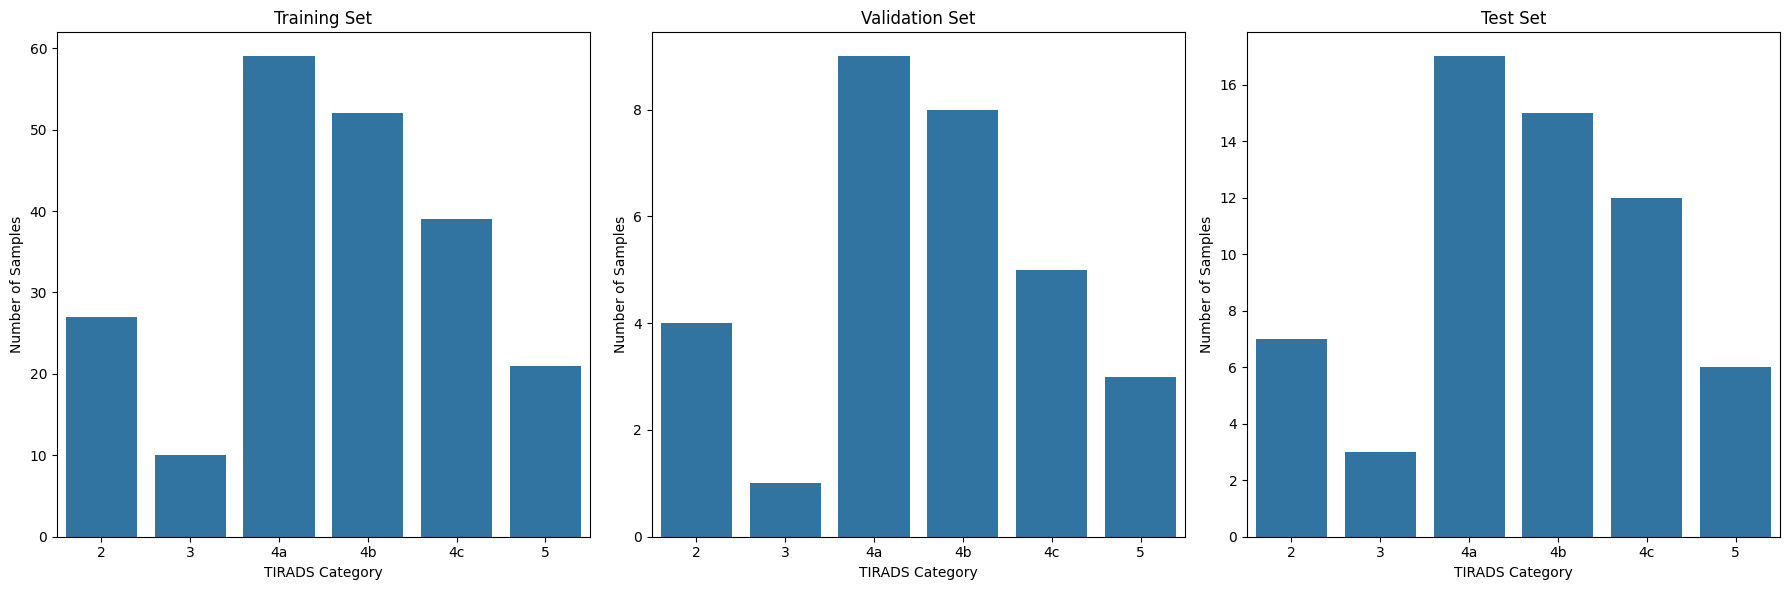

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

category_order = ['2', '3', '4a', '4b', '4c', '5']

sns.countplot(x='tirads', data=train_df, order=category_order, ax=axes[0])
axes[0].set_xlabel('TIRADS Category')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Training Set')


sns.countplot(x='tirads', data=valid_df, order=category_order, ax=axes[1])
axes[1].set_xlabel('TIRADS Category')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Validation Set')


sns.countplot(x='tirads', data=test_df, order=category_order, ax=axes[2])
axes[2].set_xlabel('TIRADS Category')
axes[2].set_ylabel('Number of Samples')
axes[2].set_title('Test Set')

plt.tight_layout()
plt.show()


### Summary of EDA

- We excluded images with `None` as the TIRADS score
- The dataset was split into train:valid:test in a 7:1:2 ratio, resulting in 298 images.
- The non-FOV (field of view) regions of the images were cropped and removed.
- Class imbalance was observed.
- A new target label was defined: cases with a TIRADS score of 4 or higher were labeled as "suspicious."


## Perform Analysis Using Deep Learning Models of your Choice, Present Discussion, and Conclusions (65 points)

### Key Concepts

Since this project is for educational purposes, I will explain key concepts in my own words.

- **Data Augmentation**  
  Data augmentation is a technique for improving a model’s generalization by generating new training samples through random transformations (such as rotation, flipping, and zooming) applied to existing images. It is especially useful with small datasets.

- **Oversampling (Upsampling)**  
  Oversampling (also called upsampling in this context) is a method for addressing class imbalance by increasing the number of samples in the minority class, either by duplicating existing samples. This helps the model avoid bias toward the majority class.

- **CNN (Convolutional Neural Networks)**  
  CNNs are a type of deep learning architecture specialized for image data. They automatically extract features efficiently. Using filters, they are particularly good at capturing local patterns such as edges and shapes.

- **Global Average Pooling (GAP)**  
  GAP averages each feature map from the last convolutional layer into a single value per channel. This results in a simpler model with fewer parameters, helping prevent overfitting, and it is suitable for capturing global features without spatial dependence.

- **Early Stopping**  
  Early stopping halts training when validation performance no longer improves. It helps prevent overfitting and enhances the model’s generalization ability.

- **Fine-tuning**  
  Fine-tuning is the process of adapting a pre-trained model to a new task. Depending on the setting, either all or some layers are tuned. This enables high performance even with limited data.

- **F1 Score**  
  The F1 score is a metric that balances precision and recall, especially useful in imbalanced datasets where accuracy alone is not informative.  
  Formula: F1 = 2 × (Precision × Recall) / (Precision + Recall)

- **ROC Curve and Precision-Recall Curve**  
  - The ROC curve shows the relationship between true positive rate (sensitivity) and false positive rate at various thresholds.
  - The Precision-Recall curve is especially helpful in imbalanced datasets. It visualizes the trade-off between precision and recall. In this project, due to the small number of negative samples, the PR curve for negatives was visualized.


### Modeling

In this task, we trained the Inception V3 model under four conditions by varying the following two factors. Inception V3 was chosen due to its versatility, accuracy, and the availability of pre-trained weights from RadImageNet.

**(1) Initial Weights: ImageNet vs. RadImageNet**  
- ImageNet is a large-scale dataset of general images, whereas RadImageNet includes radiologic images such as CT, MRI, and ultrasound.  
- Since RadImageNet shares a closer domain with this task, better performance can be expected. However, ImageNet likely provides a much larger number of pre-training samples.

> Mei, X., Liu, Z., Robson, P. M., Marinelli, B., Huang, M., Doshi, A., Jacobi, A., Cao, C., Link, K. E., Yang, T., Wang, Y., Greenspan, H., Deyer, T., Fayad, Z. A., & Yang, Y. (n.d.). *RadImageNet: An Open Radiologic Deep Learning Research Dataset for Effective Transfer Learning*. Radiology: Artificial Intelligence, 0(ja), e210315. https://doi.org/10.1148/ryai.210315

**(2) Trainable Layers: Top-only vs. All**  
- In the "top-only" setting, only the final layers after GAP are trained, keeping the rest of the model as a fixed feature extractor. This relies more heavily on pre-trained knowledge.
- In the "all layers" setting, the entire model is fine-tuned, adapting all weights to the specific task.  
- With a large dataset, full fine-tuning can specialize the model more effectively. However, in this project with limited data, it’s unclear whether enough information is available to justify training all layers.

### Upsampling Negatives

- Due to severe class imbalance, negative samples are upsampled.
- During training, different data augmentations are applied to each instance, so there are no exact duplicate samples.
- Whether to upsample the validation set is debatable. However, without upsampling, the validation loss tends to be dominated by positive samples, which sometimes leads early stopping to select models that predict everything as positive.
- Therefore, we decided to perform upsampling in the validation set. Unlike training set, this results in exact duplicate samples appearing in the validation data.

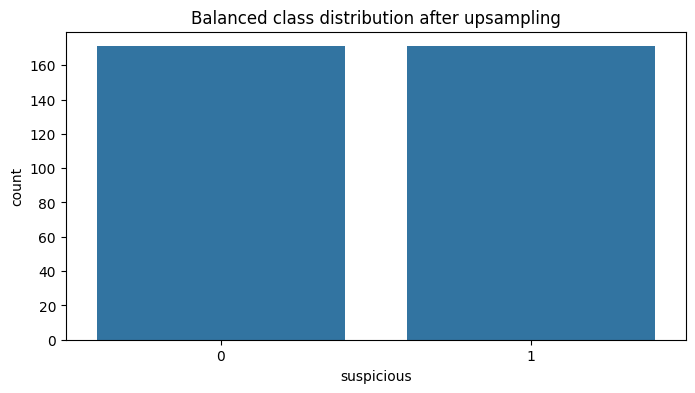

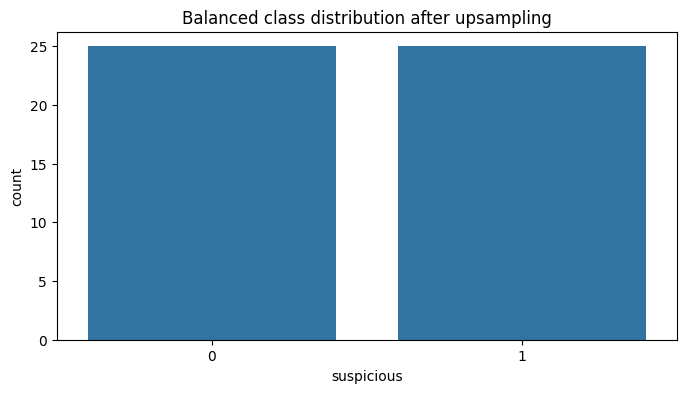

In [16]:
from sklearn.utils import resample

def upsample_negative_samples(df, seed=42):
    negative_df = df[df['suspicious'] == 0]
    positive_df = df[df['suspicious'] == 1]

    n_pos = len(positive_df)
    n_neg = len(negative_df)

    repeats = n_pos // n_neg
    remainder = n_pos % n_neg

    negative_repeated = pd.concat([negative_df] * repeats, ignore_index=True)

    # Random resampling for the remainder
    negative_extra = resample(
        negative_df,
        replace=False,
        n_samples=remainder,
        random_state=seed
    ) if remainder > 0 else pd.DataFrame()

    negative_upsampled = pd.concat([negative_repeated, negative_extra], ignore_index=True)
    upsampled_df = pd.concat([negative_upsampled, positive_df]).sample(frac=1, random_state=seed).reset_index(drop=True)

    # Visualize proof of upsampling
    plt.figure(figsize=(8, 4))
    sns.countplot(x='suspicious', data=upsampled_df, order=[0, 1])
    plt.title("Balanced class distribution after upsampling")
    plt.show()

    return upsampled_df

upsampled_train_df = upsample_negative_samples(train_df)
upsampled_valid_df = upsample_negative_samples(valid_df)

In [17]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, classification_report

batch_size = 32

def validate_model(model, valid_df, data_dir):
    X_valid = []
    y_valid = []

    for i in range(len(valid_df)):
      case_num = valid_df.iloc[i]["case_number"]
      image_filenames = [filename for filename in os.listdir(data_dir) if filename.startswith(str(case_num) + '_') and filename.endswith(".jpg")]
      image_path = os.path.join(data_dir, image_filenames[0])
      img = cv2.imread(image_path)

      # Resize and normalize
      img = cv2.resize(img, (img_width, img_height))
      img = img / 255.0

      X_valid.append(img)
      y_valid.append(valid_df.iloc[i]["suspicious"])

    X_valid = np.array(X_valid)
    y_valid = np.array(y_valid)

    y_pred_prob = model.predict(X_valid)
    y_pred = (y_pred_prob > 0.5).astype(int)


    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve for negatives
    # Because we have lots of positives, PR curve for positives will not be helpful
    # So we hereby show PR for negatives
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(1-y_valid, 1-y_pred_prob)
    average_precision = average_precision_score(1-y_valid, 1-y_pred_prob)
    plt.figure()
    plt.plot(recall, precision, lw=2, label='Precision-Recall curve for negatives (area = %0.2f)' % average_precision)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_valid, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Metrics
    accuracy = accuracy_score(y_valid, y_pred)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_valid, y_pred))

In [18]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW
from keras_radam import RAdam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Data Augmentation

- Data augmentation is essential when working with a limited sample size, as in this project.
- For medical images, which are acquired using specialized techniques, it is especially important to avoid transformations that would distort the original clinical meaning.
- For example, vertical flipping is inappropriate in this task, since in all images, the top corresponds to the skin surface and the bottom to deeper tissues.
- Likewise, large rotations are not suitable, as it is clinically unrealistic for the skin surface to be tilted. However, small rotations may be helpful, as the angle of the probe can cause slight variations in the appearance of nodules.
- Based on these clinical considerations, the following data augmentation was applied.


Found 342 validated image filenames.


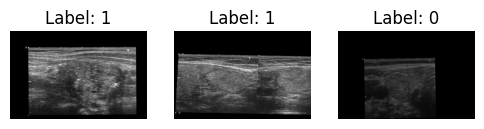

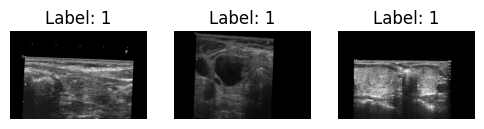

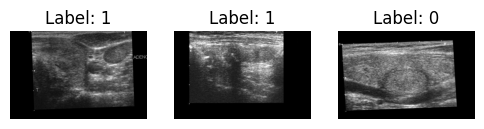

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=[0.8, 1.5],
    rotation_range=3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    fill_mode='constant',
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=upsampled_train_df,
    x_col="first_image",
    y_col="suspicious",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw', # For binary classification
    shuffle=True,
    seed=seed,
)

# Show sample images from generator
for i in range(3):
    batch_x, batch_y = next(train_generator)
    plt.figure(figsize=(6, 6))
    for j in range(3):
        plt.subplot(1, 3, j + 1)
        plt.imshow(batch_x[j])
        plt.title(f"Label: {batch_y[j]}")
        plt.axis('off')
    plt.show()

In [20]:
def experiment(weights, train_only_top, epochs=50):

  # ImageDataGenerator
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      # augmentation
      zoom_range=[0.8, 1.5],
      rotation_range=3,
      width_shift_range=0.1,
      height_shift_range=0.1,
      # channel_shift_range=30,
      brightness_range=[0.5, 1.5],
      fill_mode='constant',
  )
  valid_datagen = ImageDataGenerator(rescale=1./255)

  # flow_from_dataframe
  train_generator = train_datagen.flow_from_dataframe(
      dataframe=upsampled_train_df,
      x_col="first_image",
      y_col="suspicious",
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='raw', # For binary classification
      shuffle=True,
      seed=seed,
  )
  validation_generator = valid_datagen.flow_from_dataframe(
      dataframe=upsampled_valid_df,
      x_col="first_image",
      y_col="suspicious",
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='raw'
  )

  # Modelling
  base_model = InceptionV3(weights=weights, include_top=False, input_shape=(img_height, img_width, 3))

  # top layers
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  predictions = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=base_model.input, outputs=predictions)

  # Freeze or unfreeze feature extraction layers
  if train_only_top:
    for layer in base_model.layers:
        layer.trainable = False
  if not train_only_top:
    for layer in base_model.layers:
        layer.trainable = True

  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      start_from_epoch=10,
      patience=10,
      restore_best_weights=True,
  )

  optimizer = AdamW(learning_rate=1e-5)

  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  # Train the model
  history = model.fit(
      train_generator,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples // batch_size,
      callbacks=[early_stopping],
  )

  # Show history of losses
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  validate_model(model, test_df, data_dir)

### Experiments

#### ImageNet

Found 342 validated image filenames.
Found 50 validated image filenames.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.4461 - loss: 0.7090 - val_accuracy: 0.5000 - val_loss: 0.7012
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5020 - loss: 0.6929 - val_accuracy: 0.6562 - val_loss: 0.6899
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5480 - loss: 0.6788 - val_accuracy: 0.5000 - val_loss: 0.7045
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5760 - loss: 0.6757 - val_accuracy: 0.4688 - val_loss: 0.7094
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6589 - loss: 0.6649 - val_accuracy: 0.5000 - val_loss: 0.7015
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5973 - loss: 0.6712 - val_accuracy: 0.3750 - val_loss: 0.7102
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6744 - loss: 0.6665 - val_accuracy: 0.5625 - val_loss: 0.6681
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6456 - loss: 0.6512 - val_accuracy: 0.4375 - v

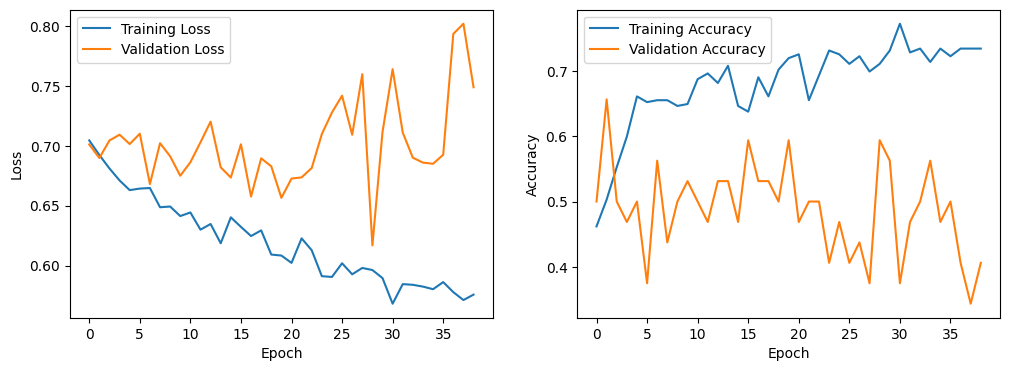

2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 15s/step


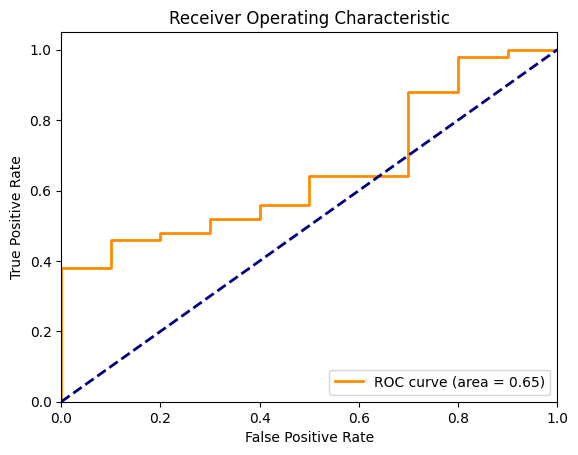

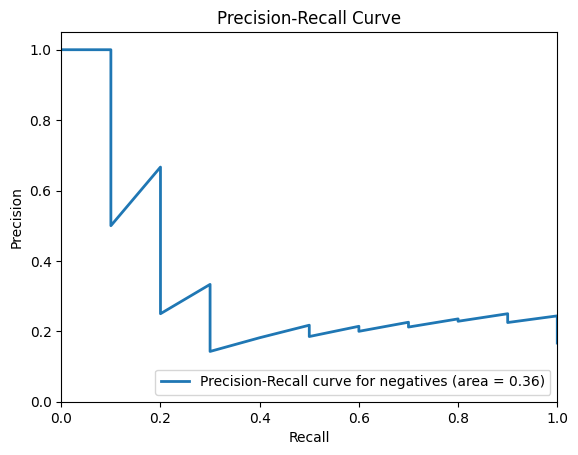

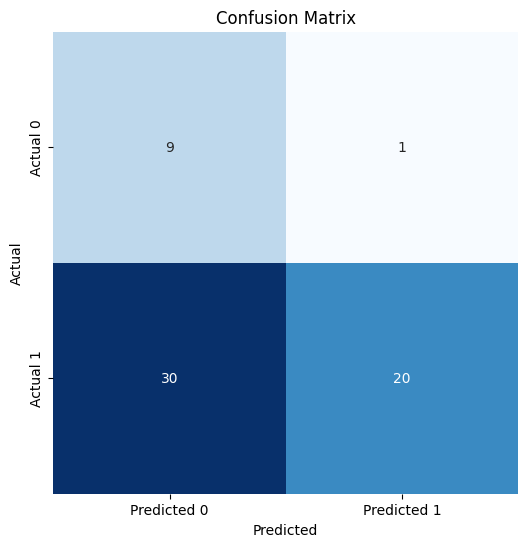

Accuracy: 0.48333333333333334
              precision    recall  f1-score   support

           0       0.23      0.90      0.37        10
           1       0.95      0.40      0.56        50

    accuracy                           0.48        60
   macro avg       0.59      0.65      0.47        60
weighted avg       0.83      0.48      0.53        60



In [21]:
experiment(weights='imagenet', train_only_top=True, epochs=100)

Found 342 validated image filenames.
Found 50 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - accuracy: 0.4675 - loss: 0.7406 - val_accuracy: 0.3750 - val_loss: 0.6901
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5715 - loss: 0.6778 - val_accuracy: 0.5312 - val_loss: 0.6948
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6099 - loss: 0.6651 - val_accuracy: 0.5625 - val_loss: 0.6807
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6678 - loss: 0.6535 - val_accuracy: 0.6250 - val_loss: 0.6587
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6637 - loss: 0.6397 - val_accuracy: 0.6250 - val_loss: 0.6621
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6875 - loss: 0.6384 - val_accuracy: 0.5312 - val_loss: 0.6818
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6961 - loss: 0.6270 - val_accuracy: 0.5000 - val_loss: 0.6850
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7762 - loss: 0.5882 - val_accuracy: 0.5000 - 

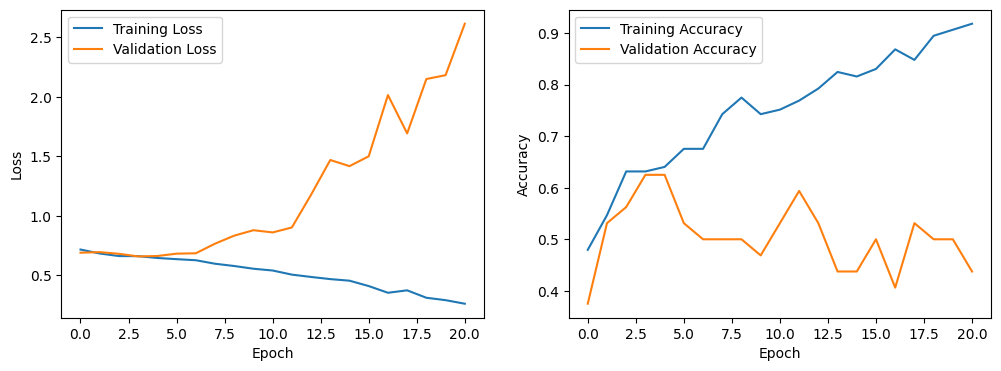

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step


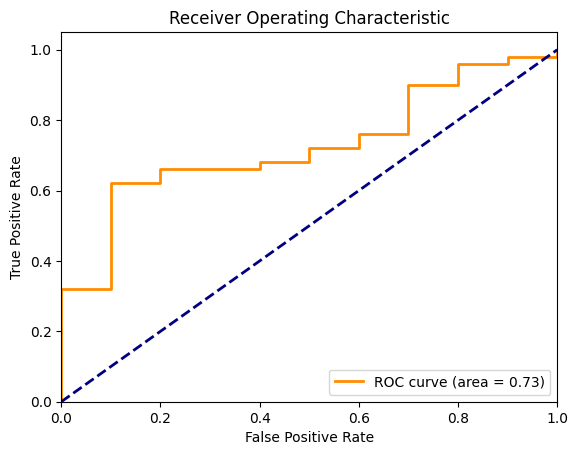

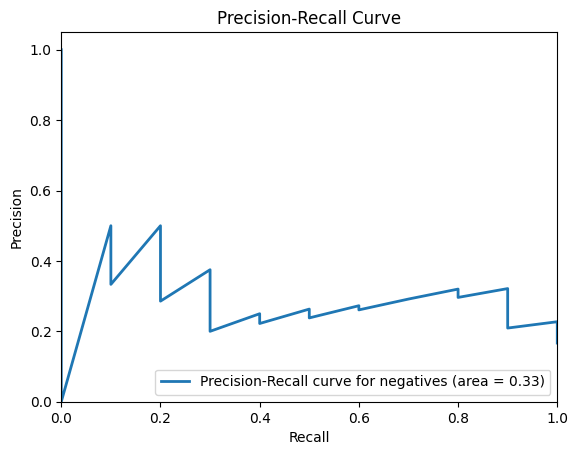

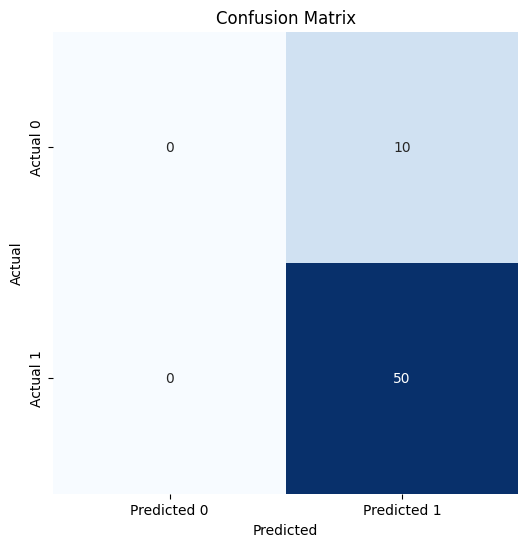

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.83      1.00      0.91        50

    accuracy                           0.83        60
   macro avg       0.42      0.50      0.45        60
weighted avg       0.69      0.83      0.76        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
experiment(weights='imagenet', train_only_top=False, epochs=100)

#### RadImageNet

In [23]:
radimagenet_weights = '/content/drive/My Drive/Education/CU/ML3/Final/RadImageNet_models/RadImageNet-InceptionV3_notop.h5'

Found 342 validated image filenames.
Found 50 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4617 - loss: 0.7076 - val_accuracy: 0.4688 - val_loss: 0.7062
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5112 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6996
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4488 - loss: 0.6989 - val_accuracy: 0.6250 - val_loss: 0.6927
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5459 - loss: 0.6909 - val_accuracy: 0.5938 - val_loss: 0.6948
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5006 - loss: 0.6932 - val_accuracy: 0.5312 - val_loss: 0.6936
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5571 - loss: 0.6908 - val_accuracy: 0.5625 - val_loss: 0.6933
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4920 - loss: 0.6930 - val_accuracy: 0.4688 - val_loss: 0.6885
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5472 - loss: 0.6903 - val_accuracy: 0.4062 - v

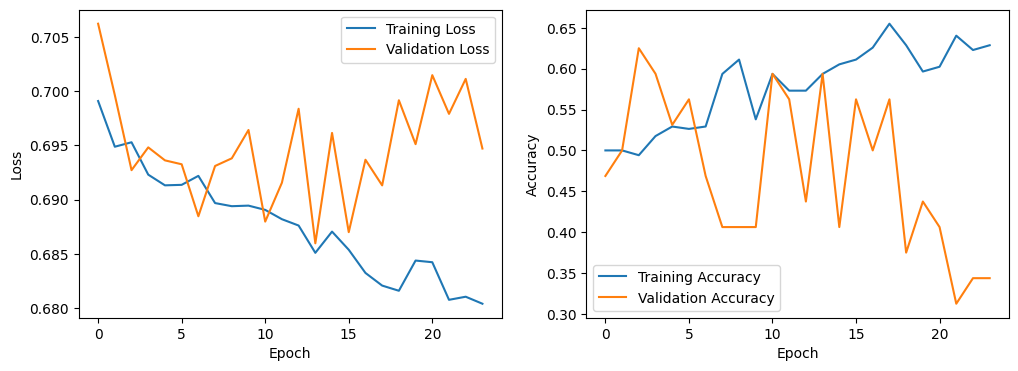

1/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step


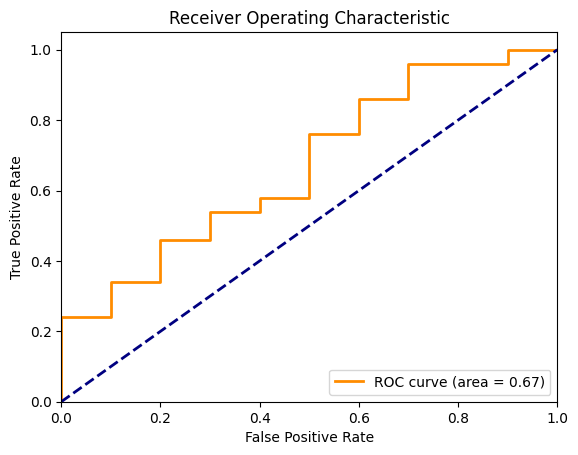

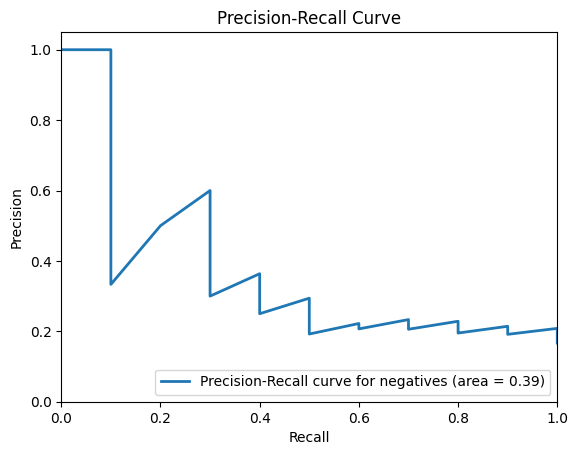

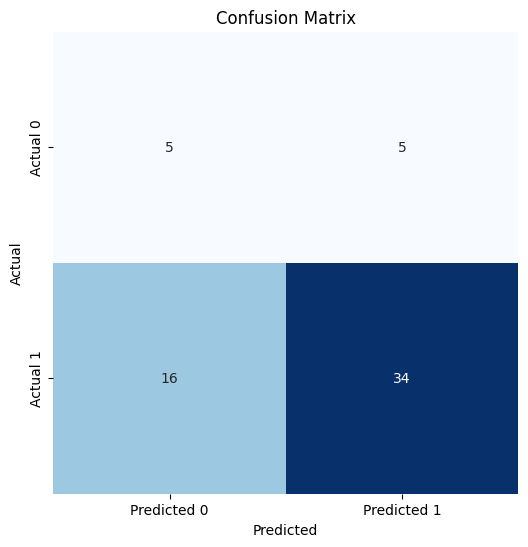

Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.24      0.50      0.32        10
           1       0.87      0.68      0.76        50

    accuracy                           0.65        60
   macro avg       0.55      0.59      0.54        60
weighted avg       0.77      0.65      0.69        60



In [24]:
experiment(weights=radimagenet_weights, train_only_top=True, epochs=100)

Found 342 validated image filenames.
Found 50 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.5184 - loss: 0.6921 - val_accuracy: 0.4688 - val_loss: 0.6991
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4832 - loss: 0.6950 - val_accuracy: 0.2812 - val_loss: 0.6944
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6052 - loss: 0.6848 - val_accuracy: 0.5000 - val_loss: 0.6950
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5777 - loss: 0.6939 - val_accuracy: 0.5625 - val_loss: 0.6891
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6372 - loss: 0.6849 - val_accuracy: 0.6875 - val_loss: 0.6944
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5720 - loss: 0.6863 - val_accuracy: 0.2812 - val_loss: 0.6966
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6377 - loss: 0.6800 - val_accuracy: 0.5000 - val_loss: 0.6915
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6310 - loss: 0.6796 - val_accuracy: 0.3125 - 

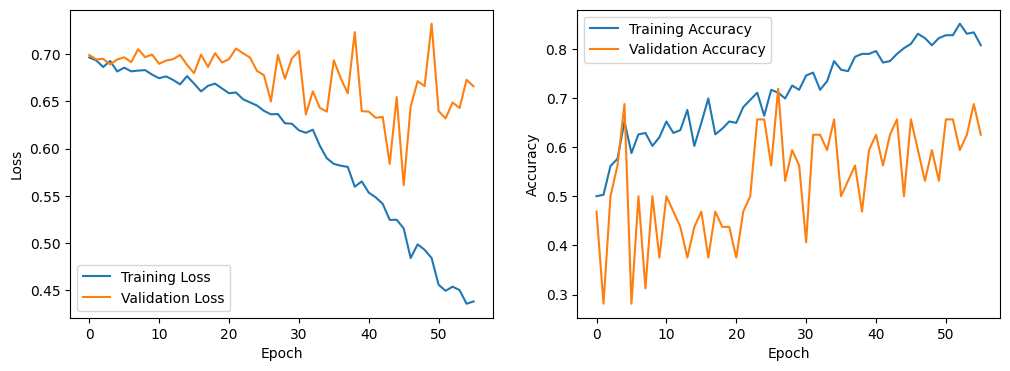

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step


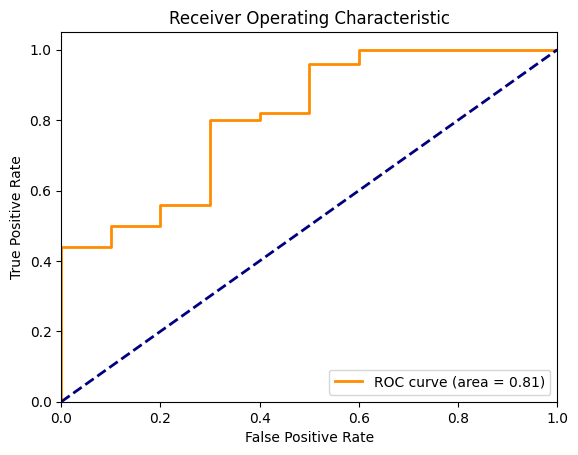

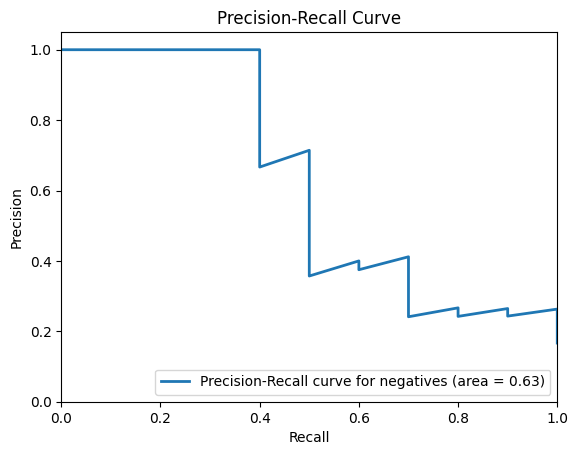

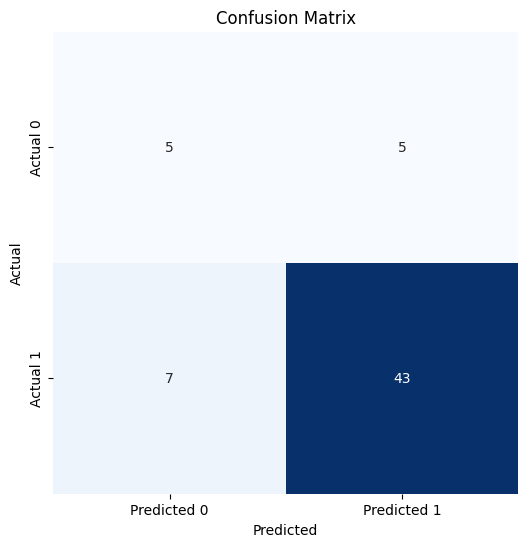

Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.42      0.50      0.45        10
           1       0.90      0.86      0.88        50

    accuracy                           0.80        60
   macro avg       0.66      0.68      0.67        60
weighted avg       0.82      0.80      0.81        60



In [25]:
experiment(weights=radimagenet_weights, train_only_top=False, epochs=100)

### Summary of Results

| Dataset     | Training   | Macro F1 | ROC-AUC | Macro Precision | Macro Recall | Accuracy |
|-------------|------------|----------|---------|------------------|---------------|----------|
| ImageNet    | only_top   | 0.47     | 0.65    | 0.59             | 0.65          | 0.48     |
| ImageNet    | all        | 0.45     | 0.73    | 0.42             | 0.50          | **0.83** |
| RadImageNet | only_top   | 0.54     | 0.67    | 0.55             | 0.59          | 0.65     |
| RadImageNet | all        | **0.67** | **0.81**| **0.66**         | **0.68**      | 0.80     |

- The highest macro F1 score, the primary evaluation metric, was achieved by the model using RadImageNet with all layers fine-tuned, scoring 0.67.
- This model also performed best across most of the other evaluation metrics, excluding accuracy, which is heavily affected by class imbalance.

### Discussion

#### Takeaways

- Pretrained weights from a domain similar to this task (RadImageNet) was found to be effective.
- Despite the small sample size, fine-tuning not only the top layers but also the feature extractor improved performance. This was likely due to the complexity of the task, which involved not only detecting the presence of tumors but also classifying them.
- Although faced with challenges such as small sample size and class imbalance, techniques like data augmentation and upsampling enabled effective model training.

#### Limitations

- The model’s performance is not yet sufficient for clinical application. This is likely due to the limited sample size, high heterogeneity within classes, and the inherent difficulty of the task.
- If this project were to be developed as a medical research study, more detailed information should be collected regarding data acquisition processes, annotation procedures, and patient backgrounds, as these are major sources of potential bias.
- The sample size also needs to be expanded. Considering the relatively high prevalence of benign thyroid tumors, increasing the number of low-TIRADS samples should not be difficult.
- Since RadImageNet performed well, pretraining on a large collection of ultrasound images alone might be even more effective.
- Additionally, some of the images come with annotations indicating the location of the nodule. These could be leveraged to improve classification performance or to tackle the problem as an object detection task.

### Disclosure
AI-assisted code completion was used in non-essential parts of the notebook.